###  **Question 1: IAQF Academic Competition**


*Imports*

In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
from datetime import date
import plotly.graph_objects as go

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

##### **a) How much of the beta is driven by the seven versus the 493 other stocks (i.e. they probably have different betas – think three)?**

**Data**

*Read*

In [2]:
# Tickers
MAG7_TICKERS = ['AAPL','MSFT','TSLA','NVDA','META','AMZN','GOOG']
INDEX_TICKER = ['SPY']

# Start/End Dates
start_date, end_date = date(2010,1,1), date(2025,1,1)

# YFinance 
prices = yf.download(tickers = MAG7_TICKERS + INDEX_TICKER, start = start_date, end = end_date,auto_adjust = True)['Close']

# Market Cap Data
market_cap_dataframes = {ticker: pd.read_csv(f"../../data/{ticker}.O.csv", index_col=0) for ticker in MAG7_TICKERS}
market_cap_dataframes['SPY'] = pd.read_csv('../../data/SPX.GI.csv',index_col=0)
market_cap_data = pd.concat(market_cap_dataframes,names = ['Ticker'])


index_tickers = ['SPX.GI','S5COND.SPI','SPN.SPI', 'S5HLTH.SPI', 'S5INFT.SPI', 'S5TELS.SPI', 'S5CONS.SPI', 'SPF.SPI', 'S5INDU.SPI',
 'S5MATR.SPI','S5UTIL.SPI','S5RLST.SPI'] 

index_ticker_industry = {'SPX.GI': 'SPY',
         'S5COND.SPI': 'Consumer Discretioanry',
         'SPN.SPI': 'Energy',
         'S5HLTH.SPI': 'Health Care',
         'S5INFT.SPI': 'Technology',
         'S5TELS.SPI': 'Communication Service',
         'S5CONS.SPI': 'Consumer Staples',
         'SPF.SPI': 'Finance',
         'S5INDU.SPI': 'Industrials',
         'S5MATR.SPI': 'Materials',
         'S5UTIL.SPI': 'Utilities',
         'S5RLST.SPI': 'Real Estates',
         }

index_dataframes = {ticker: pd.read_csv(f'../../bill/Industry Index Data/{ticker}.csv',index_col=0) for  ticker in index_tickers}
index_market_cap_data = pd.concat(index_dataframes,names = ['Ticker'])

[*********************100%***********************]  8 of 8 completed


*Cleaning*

In [3]:
# YFinance Data
prices.index = pd.to_datetime(prices.index).date
returns = prices.pct_change().dropna()

# Market Cap Data
market_cap_data = (market_cap_data
      .reset_index()
      .rename(columns = {"level_1":'date','MKT_CAP_ARD':'market_cap'})
      .pivot(index = 'date',columns='Ticker',values = 'market_cap')
)

market_cap_data.index = pd.to_datetime(market_cap_data.index).date

mag7_weights_ts = (market_cap_data[MAG7_TICKERS]
                   .div(market_cap_data['SPY'],axis = 0)
                   .dropna()
)


# Index Market Cap Data
index_market_cap_data = (index_market_cap_data
      .reset_index()
      .rename(columns = {"level_1":'date','MKT_CAP_ARD':'market_cap'})
      .pivot(index = 'date',columns='Ticker',values = 'market_cap')
)
index_market_cap_data.index = pd.to_datetime(index_market_cap_data.index).date
industry_weights_ts = index_market_cap_data.div(index_market_cap_data.sum(axis = 1),axis = 0).dropna()

# Filter for Common Index
index_intersection = mag7_weights_ts.index.intersection(returns.index)

# Filter Weights + Returns
mag7_weights_ts = mag7_weights_ts.loc[index_intersection]
returns = returns.loc[index_intersection]

**Analysis**

*i)* Market Beta Contribution

In [4]:
# Beta Calculations
window = 252
mag7_beta_ts = {ticker: (returns[ticker].rolling(window).cov(returns['SPY']) / returns['SPY'].rolling(window).var()) for ticker in MAG7_TICKERS}
mag7_beta_ts = pd.DataFrame(mag7_beta_ts)

# Weighted Beta
weighted_beta_ts = (mag7_beta_ts*mag7_weights_ts).sum(axis = 1)

**Plots**

*i)* Mag 7 Weights

In [5]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = mag7_weights_ts.sum(axis = 1).index,
        y = mag7_weights_ts.sum(axis = 1)*100,
        name = 'Mag 7 Weight',
        mode='lines',
    )
)

fig.update_layout(title = 'Magnificent 7 Index Weight',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3) 
                )
fig.update_yaxes(title = "Weight (%)")
fig.show()

*ii)* Weighted Index Beta Contribution

In [6]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x = weighted_beta_ts[window:].index,
        y = weighted_beta_ts[window:],
        name = 'Magnificent Seven',
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one',
        groupnorm='percent'
    )
)

fig.add_trace(go.Scatter(
    x= weighted_beta_ts[window:].index,
    y = 1 - weighted_beta_ts[window:], 
    mode='lines',
    name = 'Rest of Index',
    line=dict(width=0.5, color='rgb(127, 166, 238)'),
    stackgroup='one'
))

fig.update_layout(title = 'Weighted Index Beta Contribution',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  template = 'plotly_white'
                )
fig.update_yaxes(title = "Contribution %")
fig.update_xaxes(title = 'Date')
fig.show()

*iii)* Mag 7 Individual Betas

In [7]:
fig = go.Figure()

for ticker in mag7_beta_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = mag7_beta_ts[window:][ticker].index,
            y = mag7_beta_ts[window:][ticker],
            name = ticker
        )
    )

fig.update_layout(title = f'Magnificent Seven Betas, Window = {window}',
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = f"Beta")
fig.update_xaxes(title = 'Date')
fig.show()

*iv)* Normalized Mag7 Weights

In [8]:
mag7_weights_normalized_ts = mag7_weights_ts.div(mag7_weights_ts.sum(axis = 1),axis = 0)

fig = go.Figure()

for ticker in mag7_weights_normalized_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = mag7_weights_normalized_ts.index,
            y = mag7_weights_normalized_ts[ticker],
            name = ticker,
            stackgroup='one',
            groupnorm='percent'
        )
    )

fig.update_layout(title = 'Normalized Magnificent Seven Weights',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = "Weight (%)")
fig.update_xaxes(title = 'Date')
fig.show()

*iv)* Industry Weights

In [9]:
fig = go.Figure()

for ticker in industry_weights_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = industry_weights_ts.index,
            y = industry_weights_ts[ticker]*100,
            name = index_ticker_industry[ticker],
            stackgroup='one',
            groupnorm='percent'
        )
    )

fig.update_layout(title = 'Industry Weights',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = "Weight (%)")
fig.update_xaxes(title = 'Date')
fig.show()

##### **b) How does this affect the use of beta for evaluating/forecasting returns and the use of beta for investment decisions?**

**Data**

*Read*

In [25]:
# Risk Free Rate
risk_free_rate = yf.download(tickers= '^IRX',start = date(2021,1,1),end = date(2025,1,1))['Close']

# Extra Portfolio
UTILITIES_TICKERS = ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP'] #, 'CMS', 'ED']
prices_utilities = yf.download(tickers=UTILITIES_TICKERS,start = start_date,end = end_date)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed


*Cleaning*

In [26]:
# Risk Free Daily
risk_free_rate = (risk_free_rate / 100) / 252
risk_free_rate.index = pd.to_datetime(risk_free_rate.index).date

# Utilities
returns_utilites = prices_utilities.pct_change().dropna()
returns_utilites.index = pd.to_datetime(returns_utilites.index).date

**Analysis**

##### *i)* CAPM $R^2$

In [27]:
# Copy Data
returns_mag7_excess = returns[MAG7_TICKERS].copy()
returns_utilities_excess = returns_utilites[UTILITIES_TICKERS].copy()
returns_index_excess = returns[INDEX_TICKER].copy()

# Get Data Intersection
index_intersection = (returns_mag7_excess.index.intersection(returns_index_excess.index)).intersection(returns_utilities_excess.index)
returns_mag7_excess = returns_mag7_excess.loc[index_intersection]
returns_utilities_excess = returns_utilities_excess.loc[index_intersection]
returns_index_excess = returns_index_excess.loc[index_intersection]

# Calculate Excess Returns
for ticker in MAG7_TICKERS:
    returns_mag7_excess[ticker] = returns_mag7_excess[ticker] - risk_free_rate['^IRX']

for ticker in UTILITIES_TICKERS:
    returns_utilities_excess[ticker] = returns_utilities_excess[ticker] - risk_free_rate['^IRX']

for ticker in INDEX_TICKER:
    returns_index_excess[ticker] = returns_index_excess[ticker] - risk_free_rate['^IRX']

# Drop NA Values
returns_utilities_excess = returns_utilities_excess.dropna()
returns_mag7_excess = returns_mag7_excess.dropna()
returns_index_excess = returns_index_excess.dropna() 

In [28]:
def rolling_capm(asset_returns,index_returns,window_size):

    rolling_results = []
    for start_idx in range(len(index_returns) - window_size + 1):
        end_idx = start_idx + window_size
        window_data = asset_returns.iloc[start_idx:end_idx]
        date_range = window_data.index
        # Perform CAPM regressions for each asset in the window
        for ticker in asset_returns.columns:
            y = window_data[ticker].dropna()
            x = index_returns.loc[y.index].values.reshape(-1, 1)
            if len(window_data) < window_size:
                continue
            # Fit linear regression
            model = LinearRegression().fit(x, y)
            # y_pred = model.predict(x)
            beta = model.coef_[0]
            alpha = model.intercept_
            
            # Calculate R2 and MAE
            r2 = model.score(x, y)
            # mae = mean_absolute_error(y, y_pred)
            
            # Store results
            rolling_results.append({
                "Start_Date": date_range[0],
                "End_Date": date_range[-1],
                "Asset": ticker,
                'Window':window_size,
                "R2": r2,
                'Beta':beta,
                "Alpha":alpha
                # "MAE": mae,
            })
    return pd.DataFrame(rolling_results)

In [29]:
rolling_capm_mag7 = rolling_capm(returns_mag7_excess,returns_index_excess,120)
rolling_capm_mag7 = rolling_capm_mag7.pivot(index = 'End_Date',columns = 'Asset',values = 'R2')

rolling_capm_utilities = rolling_capm(returns_utilities_excess,returns_index_excess,120)
rolling_capm_utilities = rolling_capm_utilities.pivot(index = 'End_Date',columns = 'Asset',values = 'R2')

##### *ii)* Hedging Efficiency

In [30]:
def hedge_effeciency(asset_returns,benchmark_returns,risk_free_rate,lookback= 120):

    # Ensure index alignment
    ii = (asset_returns.index.intersection(benchmark_returns.index)
          .intersection(risk_free_rate.index)
        )
    
    asset_returns = asset_returns[asset_returns.index.isin(ii)]
    benchmark_returns = benchmark_returns[benchmark_returns.index.isin(ii)]
    risk_free_rate = risk_free_rate[risk_free_rate.index.isin(ii)]


    # 
    portfolio_returns = asset_returns.mean(axis = 1)
    portfolio_data = pd.DataFrame({"Portfolio":portfolio_returns,
                                  'Benchmark':benchmark_returns}
                              )
    hedge_ratios = pd.Series(index = portfolio_data.index,dtype=float)

    for i in range(lookback+1,len(portfolio_data),lookback):
        
      window_rates = risk_free_rate.iloc[i-lookback:i]
      window_returns = portfolio_returns.iloc[i-lookback:i] - window_rates
      window_benchmark_returns = benchmark_returns.iloc[i-lookback:i] - window_rates

      if window_returns.isna().any() or window_benchmark_returns.isna().any():
          continue
      X = add_constant(window_benchmark_returns)
      y = window_returns
      model = OLS(y, X).fit()
      beta = model.params[0]
          
      # Store hedge ratio
      hedge_ratios.iloc[i:i+lookback] = -beta

    hedge_ratios.ffill(inplace = True)
    portfolio_data['Hedged'] = portfolio_data['Portfolio'] + hedge_ratios * portfolio_data['Benchmark']
    
    # Compute cumulative returns
    portfolio_data['Cumulative_Portfolio'] = (1 + portfolio_data['Portfolio']).cumprod()
    portfolio_data['Cumulative_Hedged'] = (1 + portfolio_data['Hedged']).cumprod()

    # Compute Hedge Effectiveness
    portfolio_data['HE'] = 1 - (portfolio_data['Hedged'].rolling(lookback).var() / portfolio_data['Portfolio'].rolling(lookback).var())

    return portfolio_data
    

In [31]:
mag7_HE = hedge_effeciency(returns[MAG7_TICKERS],returns['SPY'],risk_free_rate['^IRX'],200)
utilities_HE = hedge_effeciency(returns_utilites[UTILITIES_TICKERS],returns['SPY'],risk_free_rate['^IRX'],200)

#### *iii)* Forecasting

*Skipped*

#### **Plots**

##### **1) CAPM Regressions**

*i)* CAPM Regression $R^2$ MAG7

In [34]:
fig = go.Figure()

for ticker in rolling_capm_mag7.columns:

    fig.add_trace(
        go.Scatter(
            x = rolling_capm_mag7.index,
            y = rolling_capm_mag7[ticker],
            name = f'{ticker}'
        )
    )
fig.update_layout(title = 'CAPM Regression R2 (MAG7)')
fig.update_layout(
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3),
                  template = 'plotly_white'
                )
fig.update_yaxes(title = 'R2',range = [0,1])
fig.show()

*ii)* CAPM Regression $R^2$ MAG7

In [35]:
fig = go.Figure()

for ticker in rolling_capm_utilities.columns:

    fig.add_trace(
        go.Scatter(
            x = rolling_capm_utilities.index,
            y = rolling_capm_utilities[ticker],
            name = f'{ticker}'
        )
    )
fig.update_layout(title = 'CAPM Regression R2 (Utilities)')
fig.update_layout(
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3),
                  template = 'plotly_white'
                )
fig.update_yaxes(title = 'R2',range = [0,1])
fig.show()

##### **2) Hedge Effeciency**

*i)* Hedge Effectiveness

In [106]:
mag7_HE = mag7_HE.dropna()
utilities_HE = utilities_HE.dropna()

In [107]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = mag7_HE.index,
        y = mag7_HE['HE'],
        name = 'Magnificent Seven'
    )
)

fig.add_trace(
    go.Scatter(
        x = utilities_HE.index,
        y = utilities_HE['HE'],
        name = 'Utilities'
    )
)

fig.update_layout(title = 'Hedge Effectiveness',
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3) 
                )
fig.update_yaxes(title = 'Hedge Effectivenss',range = [-0.1,1])
fig.update_xaxes(title = 'Date')
fig.show()

##### **c) What happens if there is a significant change in the price of one or more of those securities (especially since there may be significant interdependence due to the growth of AI investment by many of those firms)?**

**Data**

*Read*

*Clean*

**Analysis**

##### *i)* Stressed Beta, Individual Impact

In [ ]:
def stressed_beta(prices,tickers,std_threshold):

    returnsshort = np.log(prices).diff().dropna().copy()
    returnssig = returnsshort.loc[(abs(returnsshort)>std_threshold*returnsshort.std()).sum(axis=1)>0]
    
    betas = {}
    for stock in tickers:
        # Independent variable
        X = returnssig[stock].values.reshape(-1, 1)
        
        # Dependent variable
        y = returnssig['SPY'].values
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Store beta
        betas[stock] = model.coef_[0]

    betas_df = pd.DataFrame(list(betas.items()), columns=['Stock', 'Beta'])
    return betas_df

stressed_mag7_betas = stressed_beta(prices,MAG7_TICKERS,2)

##### *ii)* Downside Signigant Moves

In [37]:
def downside_returns(prices,tickers,std_threshold):

    # Calculate the standard deviation for each MAG7 stock
    std_devs = np.log(prices).diff().dropna()[tickers].std()

    mask = (np.log(prices).diff().dropna()[tickers] < -(std_threshold * std_devs)).any(axis=1)

    # Filter the dataframe for days with significant moves
    significant_moves = np.log(prices).diff().dropna()[mask]
    return significant_moves

downside_sp500_returns = downside_returns(prices,MAG7_TICKERS,2)

##### *iii)* Rolling PCA

In [57]:
def rolling_pca(prices,tickers,n_components,window_length):

    log_returns = np.log(prices).diff().dropna()[tickers]
    log_returns = (log_returns - log_returns.mean()) / log_returns.std()

    components = {}
    for i in range(window_length+1,len(log_returns)):
        window_returns = log_returns.iloc[i-window_length:i]
        dt = window_returns.index[0]
        pca = PCA(n_components)
        pca.fit(window_returns)
        loadings = pca.components_
        loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=MAG7_TICKERS)
        components[dt] = loadings_df
    return components

rolling_pca_data = rolling_pca(prices,MAG7_TICKERS,5,252)
rolling_pca_df = pd.concat(rolling_pca_data, axis=0)

PC1    0.849877
PC2    0.004579
PC3    0.093233
PC4    0.127791
PC5    0.033021
Name: Correlation with S&P 500, dtype: float64


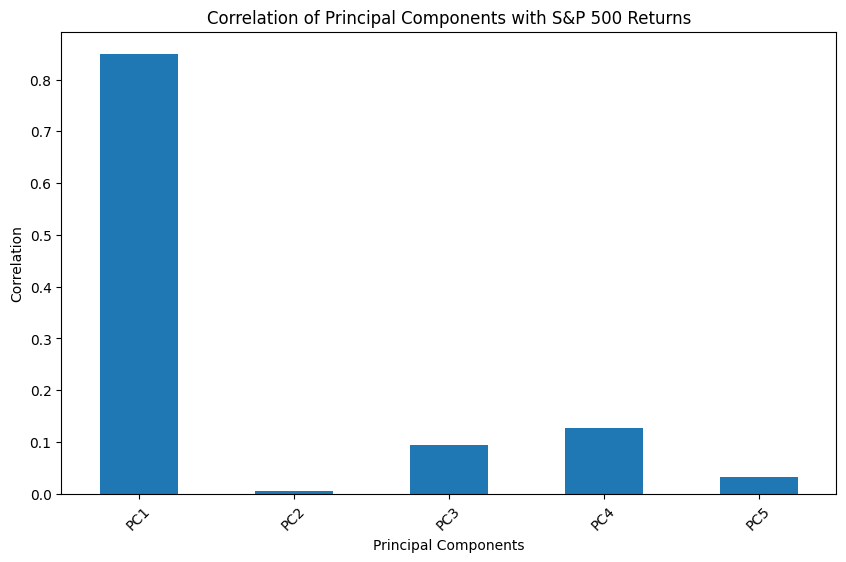

In [36]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'df' is your DataFrame containing the MAG7 returns and 'sp500_returns' is the S&P 500 returns

# Standardize the data (you've already done this when running PCA)
MAG7_returns = (returns[MAG7_TICKERS] - returns[MAG7_TICKERS].mean()) / returns[MAG7_TICKERS].std()

# Perform PCA
pca = PCA(n_components=5)  # Assume you're using the top 5 components
pca_scores = pca.fit_transform(MAG7_returns)

# Get the S&P 500 returns
sp500_returns = returns['SPY']  # Adjust this to match your S&P 500 returns column name

# Calculate the correlation between each principal component and S&P 500 returns
correlations = []
for i in range(pca_scores.shape[1]):  # Loop through all principal components
    corr = np.corrcoef(pca_scores[:, i], sp500_returns)[0, 1]
    correlations.append(corr)

# Convert the correlation results into a pandas Series for easy interpretation
correlation_df = pd.Series(correlations, index=[f'PC{i+1}' for i in range(len(correlations))], name='Correlation with S&P 500')
print(correlation_df)

# Optional: Visualize the correlations
import matplotlib.pyplot as plt
correlation_df.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation of Principal Components with S&P 500 Returns')
plt.ylabel('Correlation')
plt.xlabel('Principal Components')
plt.xticks(rotation=45)
plt.show()


In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'df' is your DataFrame containing the MAG7 returns and 'sp500_returns' is the S&P 500 returns
returns = returns[returns.index >= date(2024,1,1)]
# Standardize the data (you've already done this when running PCA)
MAG7_returns = (returns[MAG7_TICKERS] - returns[MAG7_TICKERS].mean()) / returns[MAG7_TICKERS].std()

# Perform PCA
pca = PCA(n_components=5)  # Assume you're using the top 5 components
pca_scores = pca.fit_transform(MAG7_returns)
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=MAG7_TICKERS)


In [46]:
loadings_df

,PC1,PC2,PC3,PC4,PC5
AAPL,0.318381,0.507671,-0.404816,0.587841,-0.297237
MSFT,0.466065,-0.079221,-0.136689,-0.003738,-0.052304
TSLA,0.259987,0.682347,0.514360,-0.407944,-0.084689
NVDA,0.341896,-0.218730,0.610519,0.575223,0.347842
META,0.383882,-0.437632,-0.003629,-0.162809,-0.534319
AMZN,0.447074,-0.170624,0.034001,-0.263866,-0.095184
GOOG,0.386898,0.043813,-0.423050,-0.246976,0.697274


In [49]:
loadings_df

,PC1,PC2,PC3,PC4,PC5
AAPL,0.318381,0.507671,-0.404816,0.587841,-0.297237
MSFT,0.466065,-0.079221,-0.136689,-0.003738,-0.052304
TSLA,0.259987,0.682347,0.514360,-0.407944,-0.084689
NVDA,0.341896,-0.218730,0.610519,0.575223,0.347842
META,0.383882,-0.437632,-0.003629,-0.162809,-0.534319
AMZN,0.447074,-0.170624,0.034001,-0.263866,-0.095184
GOOG,0.386898,0.043813,-0.423050,-0.246976,0.697274


In [58]:
fig = go.Figure()

# Add bars for each stock (AAPL, MSFT, etc.)
for stock in loadings_df.index:
    fig.add_trace(go.Bar(
        x=loadings_df.columns,  # Principal components (PC1, PC2, etc.)
        y=loadings_df.loc[stock],  # Weights for each component
        name=stock  # Label for the stock
    ))

# Update layout
fig.update_layout(
                  showlegend=True,
                  barmode='group',
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Principal Components',
                  yaxis_title = 'Weight',
                  xaxis=dict(title_standoff=3),
                  title = 'Magnificent 7 Return PCA Loadings',
                  template = 'plotly_white'
                )

# Show the figure
fig.show()

In [37]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = correlation_df.index,
        y = correlation_df
    )
)

fig.update_layout(title = 'PC Correlation vs SP500 returns')
fig.show()

#### **Plots**

##### *iii)* Tesla Weight on PC1

In [82]:
reset_df = rolling_pca_df.reset_index()
reset_df = reset_df[reset_df['level_1'] == 'TSLA']

In [95]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x = reset_df['level_0'],
        y = reset_df['PC1']
    )
)

fig.show()

##### **d) Does the 2024 drop in Tesla reveal anything? Is that dispositive?**

No, Telsa contributes the least?